In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge , Lasso
from sklearn import linear_model
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# PART1:
## 1.1 EDA:

In [2]:
# Import dataset
df_store_sales=pd.read_csv("Walmart_Store_sales.csv")

In [3]:
# preview of the da dataframe
print("Display of store sales dataset: ")
display(df_store_sales.head())
print()

Display of store sales dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
# number of rows in original weekly sales dataset
print("the number of rows in the original weekly sales dataset is: {}".format(len(df_store_sales["Weekly_Sales"])))
print()

the number of rows in the original weekly sales dataset is: 150



In [5]:
# Basic stats about store_sales
print("Basics statistics: ")
data_desc = df_store_sales.describe(include='all')
display(data_desc)
print()

print("number of missing values: ")
print(df_store_sales.isnull().sum())
print()

print("Percentage of missing values: ")
display(100*df_store_sales.isnull().sum()/df_store_sales.shape[0])



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



number of missing values: 
Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

### VISUALIZATIONS

In [6]:
#!pip install plotly -q
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

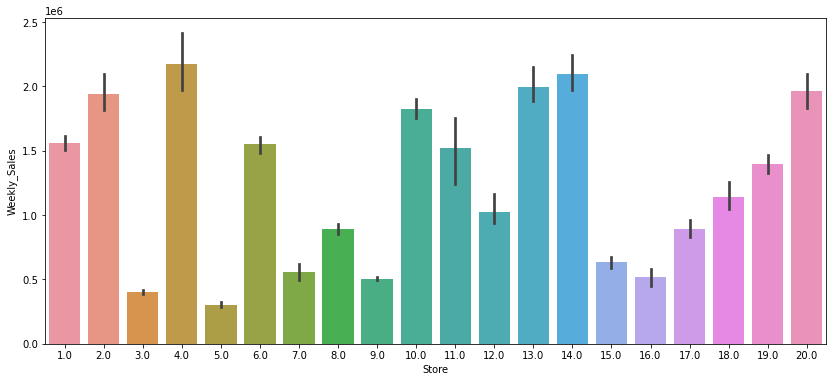

In [7]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 14,6

#visualize relation between Store and  weekly sales
sns.barplot(data=df_store_sales, x = 'Store' , y = 'Weekly_Sales') #some stores seems to have better weekly sales

In [9]:
#holidays flag distribution
df_store_sales.Holiday_Flag.value_counts()

0.0    127
1.0     11
Name: Holiday_Flag, dtype: int64

<AxesSubplot:xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

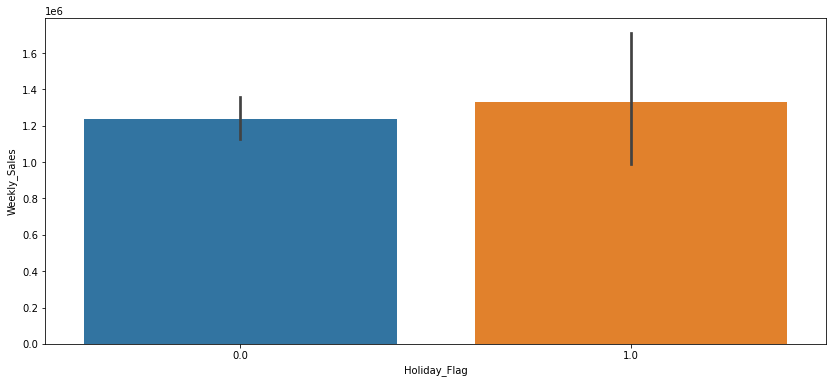

In [8]:
#visualize relation between Holiday_Flag and  weekly sales
sns.barplot(data=df_store_sales, x = 'Holiday_Flag' , y = 'Weekly_Sales')
#holidayflag has only 2 values (0 and 1) and the main data have holidayflag=0.0

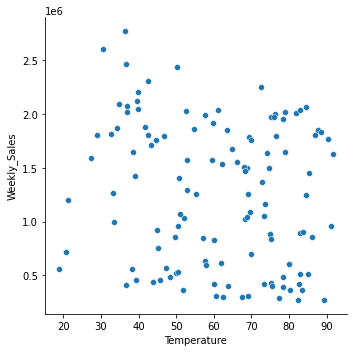

In [14]:
#visualize relation between Temperature and  weekly sales
sns.relplot(data = df_store_sales, x = 'Temperature' , y = 'Weekly_Sales')

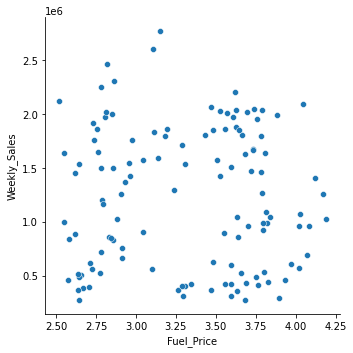

In [10]:
#visualize relation between Fuel_Price and  weekly sales
sns.relplot(data = df_store_sales, x = 'Fuel_Price' , y = 'Weekly_Sales')

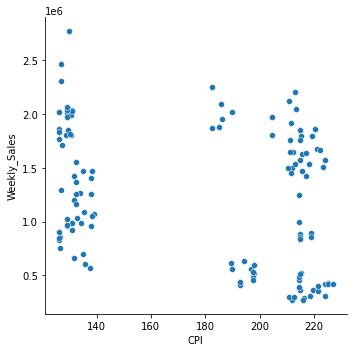

In [11]:
#visualize relation between CPI and  weekly sales
sns.relplot(data = df_store_sales, x = 'CPI' , y = 'Weekly_Sales')

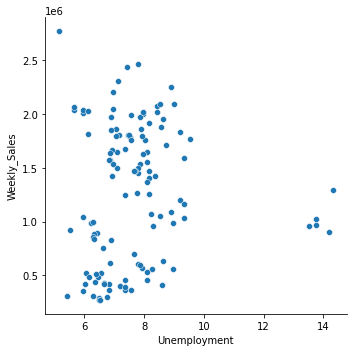

In [12]:
#visualize relation between unemployment and  weekly sales
sns.relplot(data = df_store_sales, x = 'Unemployment' , y = 'Weekly_Sales')
#we can see that there is some outliers -> (Unemployment > 13)

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

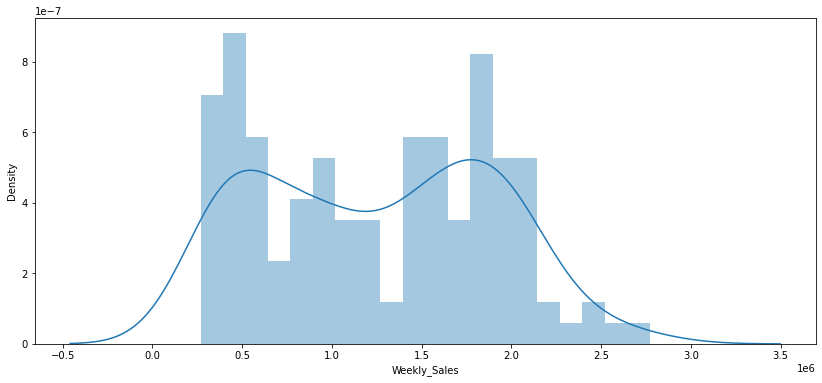

In [13]:
#visualize distribution of target value
sns.distplot(df_store_sales['Weekly_Sales'], bins=20)

## 1.2 PREPROCESSING

In [14]:
# Drop lines containing missing target value
print('Dropping the lines in the dataset for which the value in Weekly_Sales is missing...')
print()

to_keep = (df_store_sales['Weekly_Sales'].isnull()!=True) # We want keeping positives values or missings
df_store_sales = df_store_sales.loc[to_keep,:] 

print('Done. Number of lines remaining : ', df_store_sales.shape[0])

Dropping the lines in the dataset for which the value in Weekly_Sales is missing...

Done. Number of lines remaining :  136


In [15]:
df_store_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [16]:
print("Percentage of missing values after dropping messing weekly sales rows : ")
display(100*df_store_sales.isnull().sum()/df_store_sales.shape[0])

Percentage of missing values after dropping messing weekly sales rows : 


Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
dtype: float64

In [17]:
df_store_sales['Date'].value_counts()

19-10-2012    3
18-06-2010    3
25-03-2011    3
12-11-2010    3
16-03-2012    3
             ..
17-02-2012    1
02-03-2012    1
06-08-2010    1
05-02-2010    1
11-06-2010    1
Name: Date, Length: 79, dtype: int64

In [18]:
from datetime import datetime

In [19]:
df_store_sales['Date']=df_store_sales['Date'].fillna('19-10-2012')

In [20]:
df_store_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,19-10-2012,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [21]:
#convert Date to datetime
df_store_sales['Date']=[datetime.strptime(str(x), '%d-%m-%Y') for x in df_store_sales['Date']]


In [22]:
#add column day, month, year and weeklyday 

df_store_sales['day']= [x.day for x in df_store_sales['Date']]
df_store_sales['month']= [x.month for x in df_store_sales['Date']]
df_store_sales['year']= [x.year for x in df_store_sales['Date']]
df_store_sales['weekday']= [x.weekday() for x in df_store_sales['Date']]
df_store_sales.drop(columns='Date', inplace=True)


df_store_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day,month,year,weekday
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,18,2,2011,4
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,25,3,2011,4
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,19,10,2012,4
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,28,5,2010,4
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010,4


In [23]:
#unique value in weekday
df_store_sales.weekday.unique() #weekday column have a unique value 4 = Friday so we can delete it

array([4], dtype=int64)

In [24]:
#drop weekday column
df_store_sales.drop('weekday', axis=1, inplace=True)
df_store_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day,month,year
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,18,2,2011
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,25,3,2011
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,19,10,2012
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,28,5,2010
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010


##### LET VISUALIZE WEEKLY_SALE BY DATE

<AxesSubplot:xlabel='day', ylabel='Weekly_Sales'>

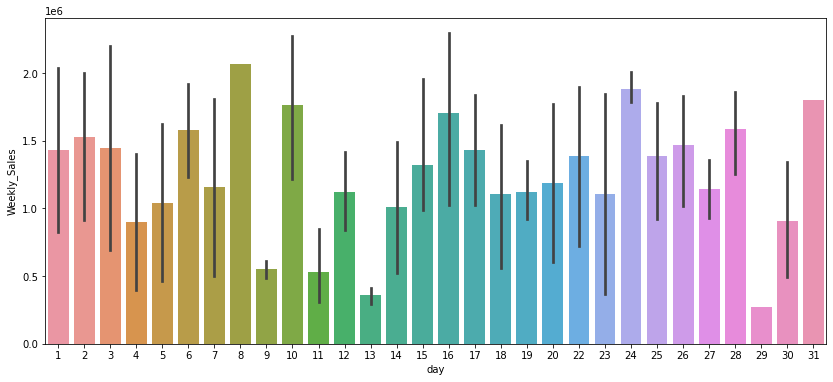

In [25]:
#visualize relation between day and  weekly sales
sns.barplot(data = df_store_sales, x = 'day' , y = 'Weekly_Sales')

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

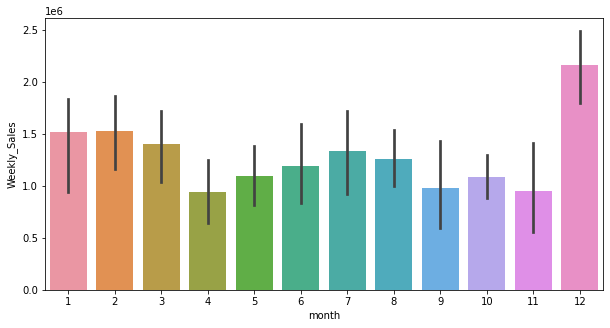

In [26]:
rcParams['figure.figsize'] = 10,5
#visualize relation between month and  weekly sales
sns.barplot(data = df_store_sales, x = 'month' , y = 'Weekly_Sales') #december seems to have more sales then the other months

<AxesSubplot:xlabel='year', ylabel='Weekly_Sales'>

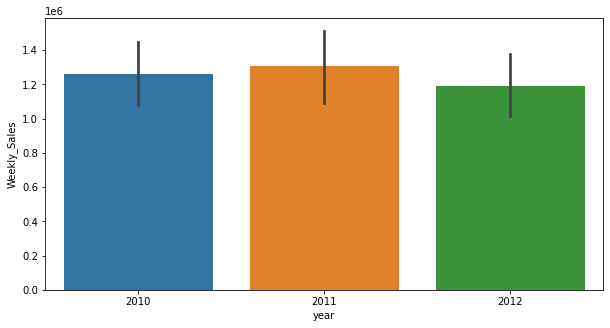

In [27]:
#visualize relation between year and  weekly sales
sns.barplot(data = df_store_sales, x = 'year' , y = 'Weekly_Sales') 

In [28]:
#convert temperature from fahrenheit to celsius
df_store_sales.Temperature=[(x-32)*(5/9) for x in df_store_sales.Temperature] 
df_store_sales.rename(columns={'Temperature':'Temperature_C°'}, inplace=True)

df_store_sales.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature_C°,Fuel_Price,CPI,Unemployment,day,month,year
0,6.0,1572117.54,NaN,15.338889,3.045,214.777523,6.858,18,2,2011
1,13.0,1807545.43,0.0,5.766667,3.435,128.616064,7.470,25,3,2011
3,11.0,1244390.03,0.0,29.205556,NaN,214.556497,7.346,19,10,2012
4,6.0,1644470.66,0.0,26.050000,2.759,212.412888,7.092,28,5,2010
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010


In [29]:
# Drop lines containing outliers (using masks) within Temperature, Fuel_price, CPI, Unemployment and Weekly_Sales
print('Dropping outliers ')
for col in ['Weekly_Sales', 'Temperature_C°', 'Fuel_Price', 'CPI', 'Unemployment']:
    to_keep = (df_store_sales[col] < df_store_sales[col].mean() + 3*df_store_sales[col].std()) & (df_store_sales[col] > df_store_sales[col].mean() - 3*df_store_sales[col].std())
    df_store_sales = df_store_sales.loc[to_keep,:]

print('Number of lines remaining : ', df_store_sales.shape[0])
print()

df_store_sales.head()

Dropping outliers 
Number of lines remaining :  90



,Store,Weekly_Sales,Holiday_Flag,Temperature_C°,Fuel_Price,CPI,Unemployment,day,month,year
0,6.0,1572117.54,NaN,15.338889,3.045,214.777523,6.858,18,2,2011
1,13.0,1807545.43,0.0,5.766667,3.435,128.616064,7.470,25,3,2011
4,6.0,1644470.66,0.0,26.050000,2.759,212.412888,7.092,28,5,2010
6,15.0,695396.19,0.0,21.000000,4.069,134.855161,7.658,3,6,2011
7,20.0,2203523.20,0.0,4.405556,3.617,213.023622,6.961,3,2,2012


In [30]:
df_store_sales.Holiday_Flag.fillna(0.0, inplace=True)

In [31]:
print("number of missing values: ")
print(df_store_sales.isnull().sum())
print()

number of missing values: 
Store             0
Weekly_Sales      0
Holiday_Flag      0
Temperature_C°    0
Fuel_Price        0
CPI               0
Unemployment      0
day               0
month             0
year              0
dtype: int64



In [32]:
df_store_sales.reset_index(drop=True,inplace=True)

In [33]:
df_store_sales.describe(include='all')

,Store,Weekly_Sales,Holiday_Flag,Temperature_C°,Fuel_Price,CPI,Unemployment,day,month,year
count,90.000000,9.000000e+01,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,9.900000,1.233865e+06,0.066667,16.145000,3.318444,179.524905,7.389733,16.444444,6.766667,2011.011111
std,6.204475,6.647250e+05,0.250841,9.858911,0.484399,39.554303,0.982729,8.079814,3.076004,0.854525
min,1.000000,2.689290e+05,0.000000,-7.338889,2.548000,126.128355,5.143000,1.000000,1.000000,2010.000000
25%,4.000000,5.617240e+05,0.000000,7.412500,2.814750,132.602339,6.642250,11.000000,4.000000,2010.000000
50%,9.000000,1.260826e+06,0.000000,16.361111,3.468000,197.166416,7.419000,18.000000,7.000000,2011.000000
75%,15.750000,1.807159e+06,0.000000,24.329167,3.737750,214.855374,8.099000,22.000000,10.000000,2012.000000
max,20.000000,2.771397e+06,1.000000,33.138889,4.170000,226.968844,9.342000,31.000000,12.000000,2012.000000


In [34]:
print("number of missing values: ")
print(df_store_sales.isnull().sum())
print()

number of missing values: 
Store             0
Weekly_Sales      0
Holiday_Flag      0
Temperature_C°    0
Fuel_Price        0
CPI               0
Unemployment      0
day               0
month             0
year              0
dtype: int64



## PREPROCESSING WITH SCIKITLEARN

In [35]:
# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = df_store_sales.loc[:,target_name]
X = df_store_sales.loc[:,[c for c in df_store_sales.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
2    1644470.66
3     695396.19
4    2203523.20
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature_C°  Fuel_Price         CPI  Unemployment  \
0    6.0           0.0       15.338889       3.045  214.777523         6.858   
1   13.0           0.0        5.766667       3.435  128.616064         7.470   
2    6.0           0.0       26.050000       2.759  212.412888         7.092   
3   15.0           0.0       21.000000       4.069  134.855161         7.658   
4   20.0           0.0        4.405556       3.617  213.023622         6.961   

   day  month  year  
0   18      2  2011  
1   25      3  2011  
2   28      5  2010  
3    3      6  2011  
4    3      2  2012  



In [36]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [37]:
# Create pipeline for numeric features
numeric_features = ['Temperature_C°', 'Fuel_Price','CPI', 'Unemployment', 'day', 'month', 'year'] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [38]:
# Create pipeline for categorical features
categorical_features = ['Store','Holiday_Flag'] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [39]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [40]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) 
print('...Done.')
print()

Performing preprocessings on train set...
...Done.

Performing preprocessings on test set...
...Done.



# Part 2 : Baseline model (linear regression)

## LINEAR REGRESSION MODEL

In [41]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [42]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[1079343.7847604  2127678.78383621  649668.08839755 2131076.61690723
  606129.93108704  530821.7754515   789124.40722658  616339.33160245
 1683207.99641697  186724.72173346  532554.11175121 1841863.61283075
 2104576.33971289 1110663.55023705 1428258.53119794 2054707.4343793
 1936046.73642024  413557.83231807 2017805.24479721  932995.528865
 1625155.2947064  2037685.83382785 1575027.98403661 1557465.74469477
 1935337.54630442  321319.39718091  514501.19123155  932301.38525542
 1531817.04922631 2018448.84958289 2063606.88952968  521228.30135507
 1911737.92337303 1623173.24391019  426255.04741991  247560.08725993
  511756.451208    435397.19       1784311.90359851 1981845.83564449
  431091.20507002 2087374.65278908 1872205.34511295  785398.577518
 1526935.59059883  471231.01701723  443694.07100661 1785494.93872493
  434728.42050989  950622.651135   2259794.08136658 1772885.72726634
 1176495.54407116 1757242.51       1941661.63324873  611475.1608984


In [43]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1585042.1493731   698941.60485269 1903709.58016681 1762091.05697075
  396710.60893184  274712.22993213 1220014.76080531 2199537.26557375
 1990690.99184096 1309242.48761077 1181491.51172493  952804.76533393
  441460.14564778  365147.63864455  526574.57356088 1355347.69095905
 2010261.40779522  405369.47403952  637481.69612855  411185.12509644
 1264247.02869863  923802.26217015 1587835.89006904 1584083.35199648
 1963784.26335673  620480.04367318 1025957.32428244]



In [44]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9870700680067128
R2 score on test set :  0.9441617285214133


In [45]:
LinearRegression_scores=[r2_score(Y_train, Y_train_pred),r2_score(Y_test, Y_test_pred)]

In [46]:
coef_list=abs(regressor.coef_)
coef_list


array([   8990.55063165,   73526.63269455,  618353.6785217 ,
         16665.06429784,   50039.01270229,   28132.43469057,
          5060.99732598,  227816.82064643, 1298164.72346941,
       1908326.1794003 , 1262239.83817201,   51344.4896823 ,
        686944.22478336,  665185.44530231, 1178456.24276353,
       1526174.27976658,  184644.78875503, 1780383.71548303,
        925485.6956516 ,  366287.50424845,  680308.3150346 ,
        563754.43597195,  751113.84867911, 1093260.74129288,
        537061.55544839,   84930.35970693])

In [47]:
feature_name_list=preprocessor.get_feature_names_out()
feature_name_list

array(['num__Temperature_C°', 'num__Fuel_Price', 'num__CPI',
       'num__Unemployment', 'num__day', 'num__month', 'num__year',
       'cat__Store_2.0', 'cat__Store_3.0', 'cat__Store_4.0',
       'cat__Store_5.0', 'cat__Store_6.0', 'cat__Store_7.0',
       'cat__Store_8.0', 'cat__Store_9.0', 'cat__Store_10.0',
       'cat__Store_11.0', 'cat__Store_13.0', 'cat__Store_14.0',
       'cat__Store_15.0', 'cat__Store_16.0', 'cat__Store_17.0',
       'cat__Store_18.0', 'cat__Store_19.0', 'cat__Store_20.0',
       'cat__Holiday_Flag_1.0'], dtype=object)

In [48]:
data={'features':feature_name_list,'coef':coef_list}
df_coef=pd.DataFrame(data=data)
df_coef.sort_values(by=['coef'], inplace=True, ascending=False)
df_coef.head(10)

,features,coef
9,cat__Store_4.0,1.908326e+06
17,cat__Store_13.0,1.780384e+06
15,cat__Store_10.0,1.526174e+06
8,cat__Store_3.0,1.298165e+06
10,cat__Store_5.0,1.262240e+06
14,cat__Store_9.0,1.178456e+06
23,cat__Store_19.0,1.093261e+06
18,cat__Store_14.0,9.254857e+05
22,cat__Store_18.0,7.511138e+05
12,cat__Store_7.0,6.869442e+05


<AxesSubplot:xlabel='coef', ylabel='features'>

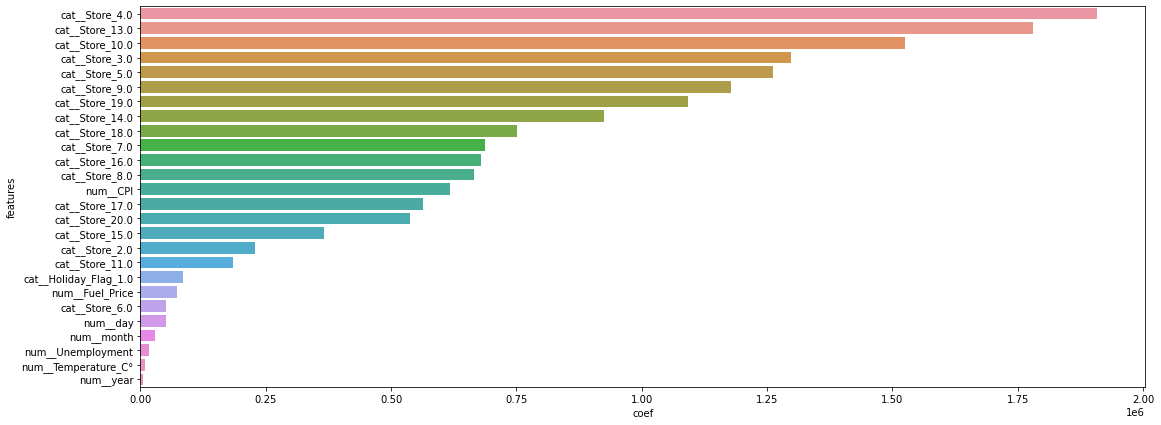

In [49]:
rcParams['figure.figsize'] = 18,7
#visualize relation between month and  weekly sales
sns.barplot(data = df_coef, x ='coef' , y =  'features')

# Part 3 : Fight overfitting

## RIDGE MODEL ALPHA=1

In [50]:
### Ridge model

In [51]:
clf1 = Ridge(alpha=1)
clf1.fit(X_train, Y_train)
print("train score:{}".format(clf1.score(X_train, Y_train)))
print("test score:{}".format(clf1.score(X_test, Y_test)))

train score:0.9252936408940631
test score:0.8274806583354138


In [52]:
ridge_scores=[clf1.score(X_train, Y_train),clf1.score(X_test, Y_test)]

In [53]:
coef_list1=["{:.2e}".format(x) for x in clf1.coef_]
print(np.array(coef_list1))

['2.29e+04' '-6.86e+04' '-6.00e+04' '1.06e+05' '-4.01e+04' '1.44e+04'
 '6.70e+04' '3.85e+05' '-7.37e+05' '6.45e+05' '-6.33e+05' '2.97e+05'
 '-7.06e+05' '-1.47e+05' '-5.25e+05' '1.12e+05' '2.21e+05' '5.32e+05'
 '4.85e+05' '-5.13e+05' '-3.17e+05' '-3.55e+05' '-3.90e+05' '-2.99e+04'
 '6.03e+05' '2.89e+04']


## LASSO MODEL ALPHA=1

In [54]:
# Lasso model
clf_lasso = Lasso(alpha=1,fit_intercept=False)
clf_lasso.fit(X_train, Y_train)

#print score
print("train score:{}".format(clf_lasso.score(X_train, Y_train)))
print("test score:{}".format(clf_lasso.score(X_test, Y_test)))

train score:0.9845695260907464
test score:0.9339683576410515


In [55]:
#save scores
lasso_scores=[clf_lasso.score(X_train, Y_train),clf_lasso.score(X_test, Y_test)]

In [56]:
coef_list=["{:.2e}".format(x) for x in clf_lasso.coef_]
print(np.array(coef_list))

['-1.89e+03' '-9.00e+04' '1.72e+06' '6.65e+04' '-5.04e+04' '1.50e+04'
 '-4.83e+04' '3.28e+05' '-1.33e+06' '4.51e+06' '-1.16e+06' '1.45e+05'
 '-7.39e+04' '-6.14e+05' '-1.12e+06' '4.10e+06' '1.64e+05' '4.33e+06'
 '1.78e+06' '2.72e+06' '1.20e+05' '3.17e+06' '3.10e+06' '3.41e+06'
 '8.11e+05' '-4.87e+04']


## GRIDSEARCH CV FOR RIDGE MODEL

In [57]:
# Perform grid search
print("Grid search...")
clf_ridge = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.001,0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(clf_ridge, param_grid = params, scoring='r2' , cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.0}


In [58]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1079343.78476043 2127678.7838362   649668.08839754 2131076.61690727
  606129.93108705  530821.77545149  789124.40722652  616339.33160246
 1683207.99641698  186724.72173344  532554.11175121 1841863.61283071
 2104576.33971291 1110663.55023708 1428258.53119793 2054707.43437932
 1936046.73642023  413557.83231807 2017805.24479719  932995.52886501
 1625155.29470639 2037685.83382779 1575027.9840366  1557465.74469477
 1935337.54630443  321319.39718091  514501.19123155  932301.38525545
 1531817.04922632 2018448.84958288 2063606.88952969  521228.30135505
 1911737.92337304 1623173.24391016  426255.04741993  247560.08725992
  511756.45120798  435397.19       1784311.90359857 1981845.83564448
  431091.20507006 2087374.65278909 1872205.34511292  785398.57751803
 1526935.59059884  471231.01701724  443694.07100663 1785494.93872494
  434728.42050986  950622.65113498 2259794.08136661 1772885.72726629
 1176495.54407109 1757242.51       1941661.63324871  611475.160

In [59]:
# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9870700680067128
R2 score on test set :  0.9441617285214107


In [60]:
#save score
grid_ridge_scores=[r2_score(Y_train, Y_train_pred),r2_score(Y_test, Y_test_pred)]

## GRIDSEARCH CV FOR LASSO MODEL

In [61]:
# Perform grid search
print("Grid search...")
clf_lasso = linear_model.Lasso(fit_intercept=False)
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch_lasso = GridSearchCV(clf_ridge, param_grid = params, scoring='r2' , cv = 5, refit=True) # cv : the number of folds to be used for CV
gridsearch_lasso.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_lasso.best_params_)
#print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.005}


In [62]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred = gridsearch_lasso.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_lasso.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[1061819.00779739 2132038.59699954  655274.75542994 2114999.4587407
  604090.50240936  535079.60970756  813429.27331625  612979.35774461
 1670837.36066777  196209.3732271   536354.92822073 1857858.33334223
 2092574.63113332 1094017.0764333  1434954.8662155  2043419.0877414
 1939212.92749857  411617.14075231 2023545.00842742  930020.17303742
 1629043.89617304 2062065.50862657 1576248.82967258 1559749.26451202
 1926851.93197437  324657.76332463  517653.57126811  924238.28464286
 1529081.05459139 2020776.14721777 2058525.37519063  526620.63047016
 1907252.63893739 1635915.7128449   417042.08568427  254598.90806191
  516949.7527204   440070.71384119 1753994.07753013 1983065.13110636
  410517.08658151 2083358.99518296 1885795.63155843  770780.11250525
 1520583.51468697  470153.08729592  433551.56666447 1773571.5243787
  449938.82807235  956891.17927503 2244605.70205153 1794679.40399474
 1205874.08893357 1756231.67698035 1951481.71409224  603151.206154

In [63]:
# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9867593217255297
R2 score on test set :  0.9440357855134026


In [64]:
#save score
grid_lasso_scores=[r2_score(Y_train, Y_train_pred),r2_score(Y_test, Y_test_pred)]

# CONCLUSION

In [65]:
#compare different scores
scores={'LinearRegression_scores':LinearRegression_scores, 'ridge_scores':ridge_scores, 'lasso_scores':lasso_scores, 'grid_ridge_scores':grid_ridge_scores,'grid_lasso_scores':grid_lasso_scores}
scores_df=pd.DataFrame(scores,index=['train','test'])
scores_df.head()

,LinearRegression_scores,ridge_scores,lasso_scores,grid_ridge_scores,grid_lasso_scores
train,0.987070,0.925294,0.984570,0.987070,0.986759
test,0.944162,0.827481,0.933968,0.944162,0.944036


-> we can see that there is a very small overfitting which is not reduced a lot with ridge and lasso models but generally the model is very well performing